In [171]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [172]:
count = 0  # digunakan untuk menghitung jumlah gambar
base_path = r'D:\UAJY\UAJY_sem_5\ML\UAS\data_paprika'
dirs = os.listdir(base_path)

for dir in dirs:
    # Gunakan os.path.join untuk menggabungkan path dengan benar
    full_path = os.path.join(base_path, dir)
    files = list(os.listdir(full_path))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

PaprikaHijau Folder has 110 Images
PaprikaKuning Folder has 110 Images
PaprikaMerah Folder has 110 Images
Images Folder has 330 Images


In [173]:
base_dir = r'data_paprika'
img_size = 180
batch = 32

In [174]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,    # Pisahkan 20% data
    subset="training",       # Ambil 80% untuk training
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 330 files belonging to 3 classes.
Using 264 files for training.


In [175]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 330 files belonging to 3 classes.
Using 66 files for validation.


In [176]:
class_names = dataset.class_names 
print("Class Names:", class_names)

Class Names: ['PaprikaHijau', 'PaprikaKuning', 'PaprikaMerah']


In [177]:
val_size = len(val_test_ds) // 2
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

print("Total Images:", len(dataset))
print("Train Images:", len(train_ds))
print("Validation Images:", len(val_ds))
print("Test Images:", len(test_ds))

Total Images: 11
Train Images: 9
Validation Images: 1
Test Images: 2


In [178]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

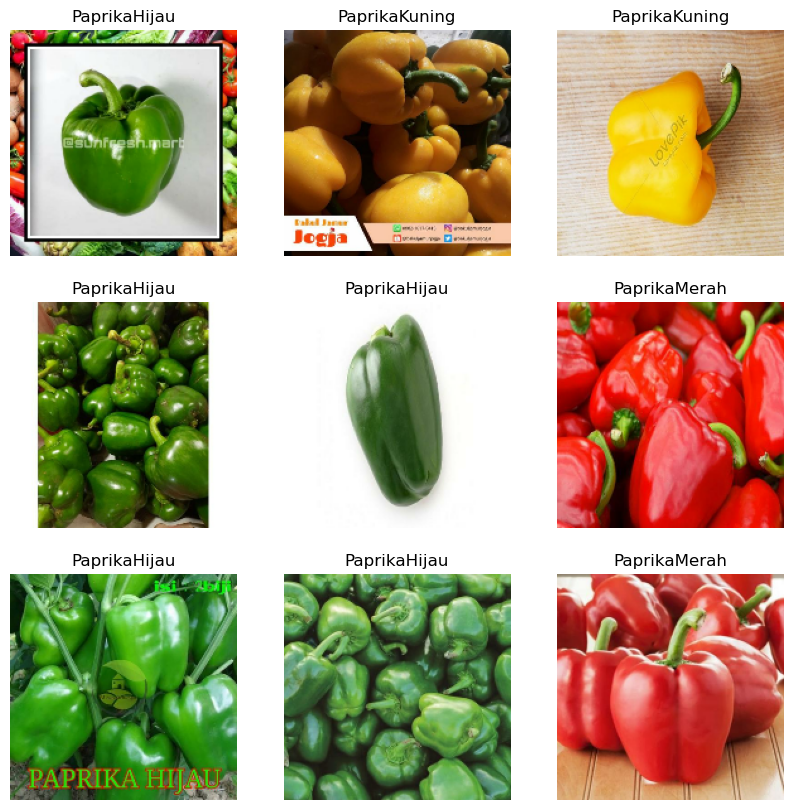

In [179]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) 

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1) 
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]]) 
        plt.axis('off') 

In [180]:
import numpy as np


for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [181]:
AUTOTUNE = tf.data.AUTOTUNE

In [182]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [183]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [184]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1) 
])

C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


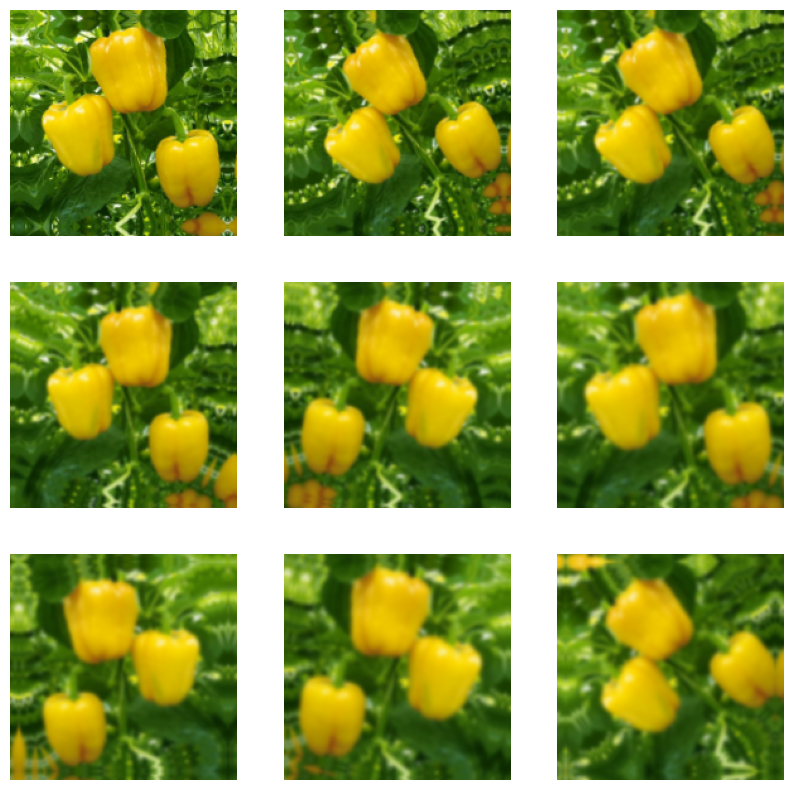

In [185]:

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(3):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [186]:
#import library yang dibutuhkan
from tensorflow.keras.applications import MobileNet #digunakan untuk memanfaatkan model yang sudah dilatih sebelumnya untuk pengenalan gambar
from tensorflow.keras.models import Model #digunakan untuk membuat dan mengonfigurasi arsitektur model

#membuat model dengan bobot yang telah dilatih sebelumnya
#include_top=False berarti tidak menggunakan lapisan klasifikasi dari mobilenet hanya bagian ekstraksi fitur
base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

#membuka (unfreeze beberapa lapisan untuk proses fine tuning)
base_model.trainable = True #seluruh model bisa dilatih
fine_tune_at = len(base_model.layers) // 2  #menentukan bahwa setengah lapisan terakhir akan di unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False #mengunci (freeze) lapisan pertama hingga setengah bagian pertama agar tidak dilatih kembali

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])    
    
#membuat model akhir dengan lapisan tambahan
###Terdapat code yang hilang disini! lihat modul untuk menemukanya


C:\Users\ACER\AppData\Local\Temp\ipykernel_13632\2025012950.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [187]:
from tensorflow.keras.optimizers import Adam #untuk mengoptimalkan proses pelatihan model

#mengkompilasi model dengan optimizer, loss function, dan metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4), #menggunakan optimizer Adam dengan learning rate 0.0001
    loss='sparse_categorical_crossentropy', #untuk klasifikasi multi-kelas
    metrics=['accuracy'] #akurasi digunakan sebagai metrik evaluasi
)


In [188]:
#menampilkan ringkasan dari model
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [189]:
#early stopping digunakan untuk menghentikan pelatihan lebih awal jika model tidak ada peningkatan
from tensorflow.keras.callbacks import EarlyStopping

#Ada fungsi early stopping disini, jangan keskip tuan :D
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=3,
                               mode='max')

#melatih model menggunakan data latih dan validasi dengan early stopping
history= model.fit(train_ds, #data pelatihan yang telah disiapkan
                   epochs=30, # jumlah maksimal epoch
                   validation_data=val_ds,  #data validasi untuk mengevaluasi model pada setiap epoch
                   callbacks=[early_stopping]) #menambahkan early stopping ke dalam callback untuk pelatihan

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 511ms/step - accuracy: 0.4416 - loss: 1.2186 - val_accuracy: 0.3000 - val_loss: 1.5862
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.7443 - loss: 0.6298 - val_accuracy: 0.4000 - val_loss: 1.3009
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - accuracy: 0.8306 - loss: 0.4017 - val_accuracy: 0.5000 - val_loss: 1.0949
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step - accuracy: 0.8866 - loss: 0.2812 - val_accuracy: 0.5000 - val_loss: 0.9794
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step - accuracy: 0.9465 - loss: 0.1775 - val_accuracy: 0.8000 - val_loss: 0.6003
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9804 - loss: 0.0908 - val_accuracy: 0.9000 - val_loss: 0.3741
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.9874 - loss: 0.0764 - val_accuracy: 0.9000 - val_loss: 0.2571
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9739 - loss: 0.0869 - val_accuracy: 0

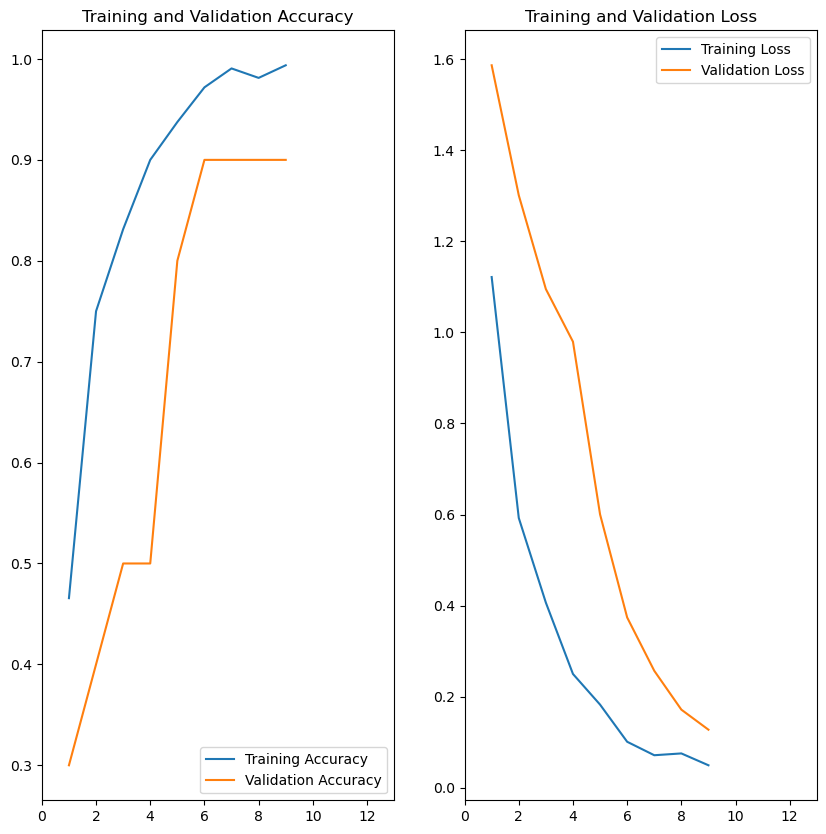

In [190]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) #membuat figure dengan ukuran 10x10 untuk menampilkan 2 grafik (Training and Validation Accuracy dan Loss)

plt.subplot(1, 2, 1) 
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy') 
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.xlim(0, 13) 
plt.title('Training and Validation Accuracy') 


plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [191]:

model.save('BestModel_MobilNetCNN_Seaborn.h5')

In [192]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'BestModel_MobilNetCNN_Seaborn.h5')  
class_names = ['PaprikaHijau', 'PaprikaKuning', 'PaprikaMerah' ] 


def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) #membuat gambar dari path dan mnegubah ukurannya menjadi 180x180 pixel
        input_image_array = tf.keras.utils.img_to_array(input_image) #mengubah gambar jadi array numpy agar bisa di proses model
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  #menambahkan dimensi batch agar sesuai dengan input model
                                                                    #dimensi menjadi (1, 180, 180, 3)

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim) #melakukan prediksi pada gambar yang telah diproses
        result = tf.nn.softmax(predictions[0]) #menghitung hasil prediksi menggunakan softmax untuk mendapatkan probabilitas tiap kelas
        class_idx = np.argmax(result) #menemukan indeks kelas dengan probabilitas tertinggi
        confidence = np.max(result) * 100 #menghitung confidence dalam persentase

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}") #menampilkan nama kelas yang diprediksi 
        print(f"Confidence: {confidence:.2f}%") #menampilkan nilai confidence

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path) #membuka gambar yang ada di path
        input_image.save(save_path) #menyimpan gambar asli ke dalam path yang telah ditentukan

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
result = classify_images(r"D:\UAJY\UAJY_sem_5\ML\UAS\data_paprika\PaprikaHijau\Green_42.jpg" , save_path='hijau.jpg')
print(result)
###Terdapat code yang hilang disini! lihat modul untuk menemukanya


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Prediksi: PaprikaHijau
Confidence: 56.10%
Prediksi: PaprikaHijau dengan confidence 56.10%. Gambar asli disimpan di hijau.jpg.


Found 330 files belonging to 3 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step


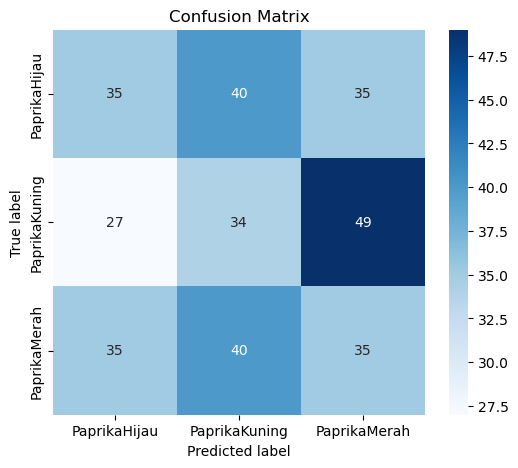

Confusion Matrix:
 [[35 40 35]
 [27 34 49]
 [35 40 35]]
Akurasi: 0.3151515151515151
Presisi: [0.36082474 0.29824561 0.29411765]
Recall: [0.31818182 0.30909091 0.31818182]
F1 Score: [0.33816425 0.30357143 0.30567686]


In [193]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

#memuat model yang telah dilatih sebelumnya
mobileNet_model = load_model(r'BestModel_MobilNetCNN_Seaborn.h5')#gunakan path masing masing ya

#memuat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'data_paprika', #direktori data uji
    labels='inferred', #label otomatis dari subfolder yang ada
    label_mode='categorical',  #menghasilkan label dalam bentuk one-hot encoding
    batch_size=32, #ukuran batch untuk pemrosesan
    image_size=(180, 180) #ukuran gambar yang akan diproses
)

#prediksi model
y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  #konversi ke kelas prediksi

#ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = [] #menyimpan label asli dalam bentuk indeks
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  #konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels) #mengkonversi list ke tensor untuk perhitungan

#membuat confusion matrix untuk evaluasi
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

#menghitung akurasi berdasarkan confusion matrix
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

#mnghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

#menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

#visualisasi Confusion Matrix
plt.figure(figsize=(6, 5)) #mengatur ukuran gambar
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', #annot=True untuk menampilkan angka di dalam setiap sel matriks
                                                                 #fmt='d' untuk menampilkan bilangan bulat tanpa desimal
            xticklabels=["PaprikaHijau", "PaprikaKuning", "PaprikaMerah"], yticklabels=["PaprikaHijau", "PaprikaKuning", "PaprikaMerah"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())


print("Veronica Regina Mambu / 220711948/ Seaborn/ Perbedaan Paprika Merah, Kuning Hijau Menggunaakn MobileNet")